In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
import json
import numpy as np
###IE###
%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images , pre_hard_skeletonize , pre_soft_skeletonize
from utils.preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset , ValidUnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from logger import save_full_report
from trainer import trainer
###SS###

# Training

In [ ]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "k":40,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.01,
    "momentum" : 0.99,
    "weight_decay" : 3e-5,
    "epcohs":15,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"dice loss",
    "alpha":0.75,
    "beta":0.25,
    "gamma":1.00,
    "f_gamma":2.0,
    "f_loss_scale":1,
    "loss_coefs":{"CE":1.0,"Second":1.0},
    "output_base_path" : "./outputs",
    "name" : "Attention7-DSV",
    "deep_super_vision" : True
}
class_map = {
    1: '1',2: '2', 3: '3',4: '4',
    5: '5',6: '6',7: '7',8: '8',
    9: '9',10: '9a',11: '10',12: '10a',
    13: '11',14: '12',15: '12a',16: '13',
    17: '14',18: '14a',19: '15',20: '16',
    21: '16a',22: '16b',23: '16c',
    24: '12b',25: '14b'
}
# losses_keys = ["total loss","FCE loss",args["loss_type"]]
losses_keys = ["total loss","CE loss",args["loss_type"]]
out_counts = 7 if args["deep_super_vision"] else 1
loss_weights = [1/(2**i) for i in range(out_counts)]
loss_weights

[1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625]

In [3]:
"""
torch.Size([10, 26, 512, 512])
torch.Size([10, 26, 256, 256])
torch.Size([10, 26, 128, 128])
torch.Size([10, 26, 64, 64])
torch.Size([10, 26, 32, 32])
torch.Size([10, 26, 16, 16])
torch.Size([10, 26, 8, 8])
"""
# model = nnUnet(args).to("cuda")
# ls = torch.ones((10,1,512,512)).float().to("cuda")
# with torch.autocast(device_type=args["device"],dtype=torch.float16):
#     outs =  model(ls)
#     for out in outs:
#         print(out.shape)

'\ntorch.Size([10, 26, 512, 512])\ntorch.Size([10, 26, 256, 256])\ntorch.Size([10, 26, 128, 128])\ntorch.Size([10, 26, 64, 64])\ntorch.Size([10, 26, 32, 32])\ntorch.Size([10, 26, 16, 16])\ntorch.Size([10, 26, 8, 8])\n'

In [4]:
# with open("./data/train_class_counts.json","r") as f:
#     train_class_counts = json.load(f)

# b = 0.999999

# counts = [0]*(len(train_class_counts))
# for k,v in train_class_counts.items():
#     counts[int(k)] = int(v)
# counts = np.array(counts,dtype=np.float64)

# f_alpha = (1-b)/(1-np.power(b,counts))
# f_alpha = f_alpha / f_alpha.sum()
# f_alpha[12] = 0.25
# # args["f_alpha"] = f_alpha.tolist()
# args["f_alpha"]=None
# args["f_alpha"]

In [5]:
b=0.999
train_class_counts = [
    1200,374,375,369,303,525,525,
    340,310,198,70,21,1,320,61,
    129,305,107,49,38,232,43,48,31,63,127
]
f_alpha = (1-b)/(1-np.power(b,train_class_counts))
print(f_alpha)

[0.00143064 0.00320357 0.00319653 0.00323937 0.0038239  0.00244738
 0.00244738 0.003468   0.00375    0.00556448 0.01478441 0.04809698
 1.         0.00365007 0.01689033 0.00825881 0.00380244 0.00985004
 0.02090204 0.0268058  0.00482751 0.02374777 0.02132692 0.03274452
 0.01637033 0.00838066]


In [6]:
# pre_soft_skeletonize(args["base_path"],output_path=args["base_path"],batch_size=10,k=40)

In [7]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ]
)
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()
    ]  
)
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None


In [8]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images,base_size=args["image_shape"][0],out_counts=out_counts)
valid_ds = ValidUnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [10]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     momentum=args["momentum"],
#     lr=args["lr"],
#     nesterov=True,
#     weight_decay=args["weight_decay"]
# )
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)
trainer(
    args=args,
    recorder = recorder,
    model = model,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_loader = train_loader,
    valid_loader = valid_loader,
    loss_weights=loss_weights)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to dice


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(3.1429, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.059166
encoders.0.layers.0.layers.0.bias: 0.000001
encoders.0.layers.0.layers.1.weight: 0.011573
encoders.0.layers.0.layers.1.bias: 0.007324
encoders.0.layers.1.layers.0.weight: 0.339834
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.022326
encoders.0.layers.1.layers.1.bias: 0.016232
encoders.1.layers.0.layers.0.weight: 0.409348
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.015722
encoders.1.layers.0.layers.1.bias: 0.005523
encoders.1.layers.1.layers.0.weight: 0.293302
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.010351
encoders.1.layers.1.layers.1.bias: 0.005385
encoders.2.layers.0.layers.0.weight: 0.165043
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.004627
encoders.2.layers.0.layers.1.bias: 0.001330
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.0525, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.039650
encoders.0.layers.0.layers.0.bias: 0.000001
encoders.0.layers.0.layers.1.weight: 0.002925
encoders.0.layers.0.layers.1.bias: 0.002730
encoders.0.layers.1.layers.0.weight: 0.010331
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.005076
encoders.0.layers.1.layers.1.bias: 0.002795
encoders.1.layers.0.layers.0.weight: 0.009101
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.001165
encoders.1.layers.0.layers.1.bias: 0.001115
encoders.1.layers.1.layers.0.weight: 0.002991
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.000765
encoders.1.layers.1.layers.1.bias: 0.000524
encoders.2.layers.0.layers.0.weight: 0.000056
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.000011
encoders.2.layers.0.layers.1.bias: 0.000014
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.1349, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.127323
encoders.0.layers.0.layers.0.bias: 0.000001
encoders.0.layers.0.layers.1.weight: 0.004739
encoders.0.layers.0.layers.1.bias: 0.002090
encoders.0.layers.1.layers.0.weight: 0.015987
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.007980
encoders.0.layers.1.layers.1.bias: 0.003007
encoders.1.layers.0.layers.0.weight: 0.014989
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.003529
encoders.1.layers.0.layers.1.bias: 0.003131
encoders.1.layers.1.layers.0.weight: 0.007391
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.002724
encoders.1.layers.1.layers.1.bias: 0.001700
encoders.2.layers.0.layers.0.weight: 0.000393
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.000063
encoders.2.layers.0.layers.1.bias: 0.000049
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.2831, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.275613
encoders.0.layers.0.layers.0.bias: 0.000001
encoders.0.layers.0.layers.1.weight: 0.009544
encoders.0.layers.0.layers.1.bias: 0.007947
encoders.0.layers.1.layers.0.weight: 0.025586
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.006856
encoders.0.layers.1.layers.1.bias: 0.005655
encoders.1.layers.0.layers.0.weight: 0.015328
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.003451
encoders.1.layers.0.layers.1.bias: 0.003900
encoders.1.layers.1.layers.0.weight: 0.007171
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.002240
encoders.1.layers.1.layers.1.bias: 0.002015
encoders.2.layers.0.layers.0.weight: 0.000528
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.000157
encoders.2.layers.0.layers.1.bias: 0.000072
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4)
total loss : 0.21429924182593824 - CE loss : 0.3118429426848888 - dice loss : -0.09754369907081127

train avg metrics for epoch 4 :
avg dice : 0.07817609953097551 - avg precision : 0.10930390555411577 - avg recall : 0.07585448323568017
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4)
total loss : 0.061383992061018945 - CE loss : 0.14559419490396977 - dice loss : -0.08421020284295082

valid avg metrics for epoch 4 :
avg dice : 0.09766241929379973 - avg precision : 0.14378339238464832 - avg recall : 0.08492424213742197
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.2414, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.209022
encoders.0.layers.0.layers.0.bias: 0.000002
encoders.0.layers.0.layers.1.weight: 0.010643
encoders.0.layers.0.layers.1.bias: 0.007620
encoders.0.layers.1.layers.0.weight: 0.015657
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.011017
encoders.0.layers.1.layers.1.bias: 0.007807
encoders.1.layers.0.layers.0.weight: 0.014740
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.009409
encoders.1.layers.0.layers.1.bias: 0.008094
encoders.1.layers.1.layers.0.weight: 0.013341
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.008608
encoders.1.layers.1.layers.1.bias: 0.007822
encoders.2.layers.0.layers.0.weight: 0.001188
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.000420
encoders.2.layers.0.layers.1.bias: 0.000600
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6)
total loss : 0.11681411426980048 - CE loss : 0.29636977553367616 - dice loss : -0.17955566540360451

train avg metrics for epoch 6 :
avg dice : 0.14975731033176726 - avg precision : 0.16342753201723098 - avg recall : 0.14521757426904514
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6)
total loss : 0.0105006393045187 - CE loss : 0.14518251307308674 - dice loss : -0.13468187376856805

valid avg metrics for epoch 6 :
avg dice : 0.15800305588440186 - avg precision : 0.1747740014642477 - avg recall : 0.17150453738402574
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.2388, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.154563
encoders.0.layers.0.layers.0.bias: 0.000002
encoders.0.layers.0.layers.1.weight: 0.014398
encoders.0.layers.0.layers.1.bias: 0.010270
encoders.0.layers.1.layers.0.weight: 0.021869
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.016008
encoders.0.layers.1.layers.1.bias: 0.009272
encoders.1.layers.0.layers.0.weight: 0.027507
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.017818
encoders.1.layers.0.layers.1.bias: 0.012940
encoders.1.layers.1.layers.0.weight: 0.020675
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.014710
encoders.1.layers.1.layers.1.bias: 0.009612
encoders.2.layers.0.layers.0.weight: 0.002252
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.000575
encoders.2.layers.0.layers.1.bias: 0.000908
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4208, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.378204
encoders.0.layers.0.layers.0.bias: 0.000002
encoders.0.layers.0.layers.1.weight: 0.019333
encoders.0.layers.0.layers.1.bias: 0.015804
encoders.0.layers.1.layers.0.weight: 0.039067
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.021129
encoders.0.layers.1.layers.1.bias: 0.014907
encoders.1.layers.0.layers.0.weight: 0.032368
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.021937
encoders.1.layers.0.layers.1.bias: 0.020428
encoders.1.layers.1.layers.0.weight: 0.025778
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.014552
encoders.1.layers.1.layers.1.bias: 0.008966
encoders.2.layers.0.layers.0.weight: 0.001023
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.000188
encoders.2.layers.0.layers.1.bias: 0.000297
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9)
total loss : 0.02672024145256728 - CE loss : 0.2757673552632332 - dice loss : -0.249047110080719

train avg metrics for epoch 9 :
avg dice : 0.19901161018801264 - avg precision : 0.2237513130903244 - avg recall : 0.19481085328385234
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9)
total loss : 0.03236365243792534 - CE loss : 0.16480742320418357 - dice loss : -0.13244377076625824

valid avg metrics for epoch 9 :
avg dice : 0.16184795697878673 - avg precision : 0.1916192000359297 - avg recall : 0.15442088096533552
1 => dice : 0.40557751059532166 p : 0.41439634561538696 , r : 0.3971261978149414
2 => dice : 0.5592934489250183 p : 0.6790629029273987 , r : 0.4754382371902466
3 => dice : 0.39515578746795654 p : 0.4778452515602112 , r : 0.33686283230781555
4 => dice : 0.24766084551811218 p : 0.24584849178791046 , r : 0.2495001256465912
5 => dice : 0.46500954031944275 p : 0.5257903933525085 , r : 0.41682499647140503
6 => dice : 0.3550564050674

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3106, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.223170
encoders.0.layers.0.layers.0.bias: 0.000003
encoders.0.layers.0.layers.1.weight: 0.019479
encoders.0.layers.0.layers.1.bias: 0.014242
encoders.0.layers.1.layers.0.weight: 0.030082
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.020176
encoders.0.layers.1.layers.1.bias: 0.012343
encoders.1.layers.0.layers.0.weight: 0.029345
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.020490
encoders.1.layers.0.layers.1.bias: 0.012912
encoders.1.layers.1.layers.0.weight: 0.019665
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.018101
encoders.1.layers.1.layers.1.bias: 0.008376
encoders.2.layers.0.layers.0.weight: 0.003019
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.000860
encoders.2.layers.0.layers.1.bias: 0.000638
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (11)
total loss : -0.007068554004654289 - CE loss : 0.26783173978328706 - dice loss : -0.2749002891778946

train avg metrics for epoch 11 :
avg dice : 0.21752635754220764 - avg precision : 0.23232659190893173 - avg recall : 0.21378919907612726
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11)
total loss : -0.06437229849398136 - CE loss : 0.12721739821135997 - dice loss : -0.19158969670534134

valid avg metrics for epoch 11 :
avg dice : 0.2247397732668196 - avg precision : 0.2513245002925396 - avg recall : 0.2174070530361496
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (12)
total loss : -0.013337870484683663 - CE loss : 0.26736477300524714 - dice loss : -0.28070264667272565

train avg metrics for epoch 12 :
avg dice : 0.22371318876785246 - avg precision : 0.23946316353976727 - avg recall : 0.21768502281978727
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12)
total loss : -0.06066989004611969 - CE loss : 0.12583338804543018 - dice loss : -0.18650327809154987

valid avg metrics for epoch 12 :
avg dice : 0.22502097450230404 - avg precision : 0.2726144003868103 - avg recall : 0.20242064490914344
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6979, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.674629
encoders.0.layers.0.layers.0.bias: 0.000002
encoders.0.layers.0.layers.1.weight: 0.027420
encoders.0.layers.0.layers.1.bias: 0.026641
encoders.0.layers.1.layers.0.weight: 0.039268
encoders.0.layers.1.layers.0.bias: 0.000001
encoders.0.layers.1.layers.1.weight: 0.031896
encoders.0.layers.1.layers.1.bias: 0.023319
encoders.1.layers.0.layers.0.weight: 0.028501
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.022458
encoders.1.layers.0.layers.1.bias: 0.018922
encoders.1.layers.1.layers.0.weight: 0.015656
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.011322
encoders.1.layers.1.layers.1.bias: 0.006654
encoders.2.layers.0.layers.0.weight: 0.002874
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.001504
encoders.2.layers.0.layers.1.bias: 0.001061
encoders.2.layers.1.layer

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(nan, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: nan
encoders.0.layers.0.layers.0.bias: nan
encoders.0.layers.0.layers.1.weight: nan
encoders.0.layers.0.layers.1.bias: nan
encoders.0.layers.1.layers.0.weight: nan
encoders.0.layers.1.layers.0.bias: nan
encoders.0.layers.1.layers.1.weight: nan
encoders.0.layers.1.layers.1.bias: nan
encoders.1.layers.0.layers.0.weight: nan
encoders.1.layers.0.layers.0.bias: nan
encoders.1.layers.0.layers.1.weight: nan
encoders.1.layers.0.layers.1.bias: nan
encoders.1.layers.1.layers.0.weight: nan
encoders.1.layers.1.layers.0.bias: nan
encoders.1.layers.1.layers.1.weight: nan
encoders.1.layers.1.layers.1.bias: nan
encoders.2.layers.0.layers.0.weight: nan
encoders.2.layers.0.layers.0.bias: nan
encoders.2.layers.0.layers.1.weight: nan
encoders.2.layers.0.layers.1.bias: nan
encoders.2.layers.1.layers.0.weight: nan
encoders.2.layers.1.layers.0.bias: nan
encoders.2.layers.1.layers.1.weight: nan
encoder

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(nan, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: nan
encoders.0.layers.0.layers.0.bias: nan
encoders.0.layers.0.layers.1.weight: nan
encoders.0.layers.0.layers.1.bias: nan
encoders.0.layers.1.layers.0.weight: nan
encoders.0.layers.1.layers.0.bias: nan
encoders.0.layers.1.layers.1.weight: nan
encoders.0.layers.1.layers.1.bias: nan
encoders.1.layers.0.layers.0.weight: nan
encoders.1.layers.0.layers.0.bias: nan
encoders.1.layers.0.layers.1.weight: nan
encoders.1.layers.0.layers.1.bias: nan
encoders.1.layers.1.layers.0.weight: nan
encoders.1.layers.1.layers.0.bias: nan
encoders.1.layers.1.layers.1.weight: nan
encoders.1.layers.1.layers.1.bias: nan
encoders.2.layers.0.layers.0.weight: nan
encoders.2.layers.0.layers.0.bias: nan
encoders.2.layers.0.layers.1.weight: nan
encoders.2.layers.0.layers.1.bias: nan
encoders.2.layers.1.layers.0.weight: nan
encoders.2.layers.1.layers.0.bias: nan
encoders.2.layers.1.layers.1.weight: nan
encoder

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0., device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 0.000000
encoders.0.layers.0.layers.0.bias: 0.000000
encoders.0.layers.0.layers.1.weight: 0.000000
encoders.0.layers.0.layers.1.bias: 0.000000
encoders.0.layers.1.layers.0.weight: 0.000000
encoders.0.layers.1.layers.0.bias: 0.000000
encoders.0.layers.1.layers.1.weight: 0.000000
encoders.0.layers.1.layers.1.bias: 0.000000
encoders.1.layers.0.layers.0.weight: 0.000000
encoders.1.layers.0.layers.0.bias: 0.000000
encoders.1.layers.0.layers.1.weight: 0.000000
encoders.1.layers.0.layers.1.bias: 0.000000
encoders.1.layers.1.layers.0.weight: 0.000000
encoders.1.layers.1.layers.0.bias: 0.000000
encoders.1.layers.1.layers.1.weight: 0.000000
encoders.1.layers.1.layers.1.bias: 0.000000
encoders.2.layers.0.layers.0.weight: 0.000000
encoders.2.layers.0.layers.0.bias: 0.000000
encoders.2.layers.0.layers.1.weight: 0.000000
encoders.2.layers.0.layers.1.bias: 0.000000
encoders.2.layers.1.layers.0.

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (17)
total loss : nan - CE loss : nan - dice loss : nan

train avg metrics for epoch 17 :
avg dice : 0.05529528803234804 - avg precision : 0.15623658400028945 - avg recall : 0.038906655119499194
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17)
total loss : nan - CE loss : nan - dice loss : nan

valid avg metrics for epoch 17 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(nan, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: nan
encoders.0.layers.0.layers.0.bias: nan
encoders.0.layers.0.layers.1.weight: nan
encoders.0.layers.0.layers.1.bias: nan
encoders.0.layers.1.layers.0.weight: nan
encoders.0.layers.1.layers.0.bias: nan
encoders.0.layers.1.layers.1.weight: nan
encoders.0.layers.1.layers.1.bias: nan
encoders.1.layers.0.layers.0.weight: nan
encoders.1.layers.0.layers.0.bias: nan
encoders.1.layers.0.layers.1.weight: nan
encoders.1.layers.0.layers.1.bias: nan
encoders.1.layers.1.layers.0.weight: nan
encoders.1.layers.1.layers.0.bias: nan
encoders.1.layers.1.layers.1.weight: nan
encoders.1.layers.1.layers.1.bias: nan
encoders.2.layers.0.layers.0.weight: nan
encoders.2.layers.0.layers.0.bias: nan
encoders.2.layers.0.layers.1.weight: nan
encoders.2.layers.0.layers.1.bias: nan
encoders.2.layers.1.layers.0.weight: nan
encoders.2.layers.1.layers.0.bias: nan
encoders.2.layers.1.layers.1.weight: nan
encoder

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(nan, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: nan
encoders.0.layers.0.layers.0.bias: nan
encoders.0.layers.0.layers.1.weight: nan
encoders.0.layers.0.layers.1.bias: nan
encoders.0.layers.1.layers.0.weight: nan
encoders.0.layers.1.layers.0.bias: nan
encoders.0.layers.1.layers.1.weight: nan
encoders.0.layers.1.layers.1.bias: nan
encoders.1.layers.0.layers.0.weight: nan
encoders.1.layers.0.layers.0.bias: nan
encoders.1.layers.0.layers.1.weight: nan
encoders.1.layers.0.layers.1.bias: nan
encoders.1.layers.1.layers.0.weight: nan
encoders.1.layers.1.layers.0.bias: nan
encoders.1.layers.1.layers.1.weight: nan
encoders.1.layers.1.layers.1.bias: nan
encoders.2.layers.0.layers.0.weight: nan
encoders.2.layers.0.layers.0.bias: nan
encoders.2.layers.0.layers.1.weight: nan
encoders.2.layers.0.layers.1.bias: nan
encoders.2.layers.1.layers.0.weight: nan
encoders.2.layers.1.layers.0.bias: nan
encoders.2.layers.1.layers.1.weight: nan
encoder

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(nan, device='cuda:0')

--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: nan
encoders.0.layers.0.layers.0.bias: nan
encoders.0.layers.0.layers.1.weight: nan
encoders.0.layers.0.layers.1.bias: nan
encoders.0.layers.1.layers.0.weight: nan
encoders.0.layers.1.layers.0.bias: nan
encoders.0.layers.1.layers.1.weight: nan
encoders.0.layers.1.layers.1.bias: nan
encoders.1.layers.0.layers.0.weight: nan
encoders.1.layers.0.layers.0.bias: nan
encoders.1.layers.0.layers.1.weight: nan
encoders.1.layers.0.layers.1.bias: nan
encoders.1.layers.1.layers.0.weight: nan
encoders.1.layers.1.layers.0.bias: nan
encoders.1.layers.1.layers.1.weight: nan
encoders.1.layers.1.layers.1.bias: nan
encoders.2.layers.0.layers.0.weight: nan
encoders.2.layers.0.layers.0.bias: nan
encoders.2.layers.0.layers.1.weight: nan
encoders.2.layers.0.layers.1.bias: nan
encoders.2.layers.1.layers.0.weight: nan
encoders.2.layers.1.layers.0.bias: nan
encoders.2.layers.1.layers.1.weight: nan
encoder

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results
builfding kaggle project


100%|██████████| 9/9 [00:00<00:00, 2652.01it/s]


processing ./utils/dataset.py
processing ./utils/helpers.py
processing ./logger.py
processing ./utils/preprocessing.py
processing ./utils/recorder.py
processing ./models/nnunet_blocks.py
processing ./models/nnunet.py
processing ./utils/losses.py
processing ./trainer.py


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

processing ./temp_script.py


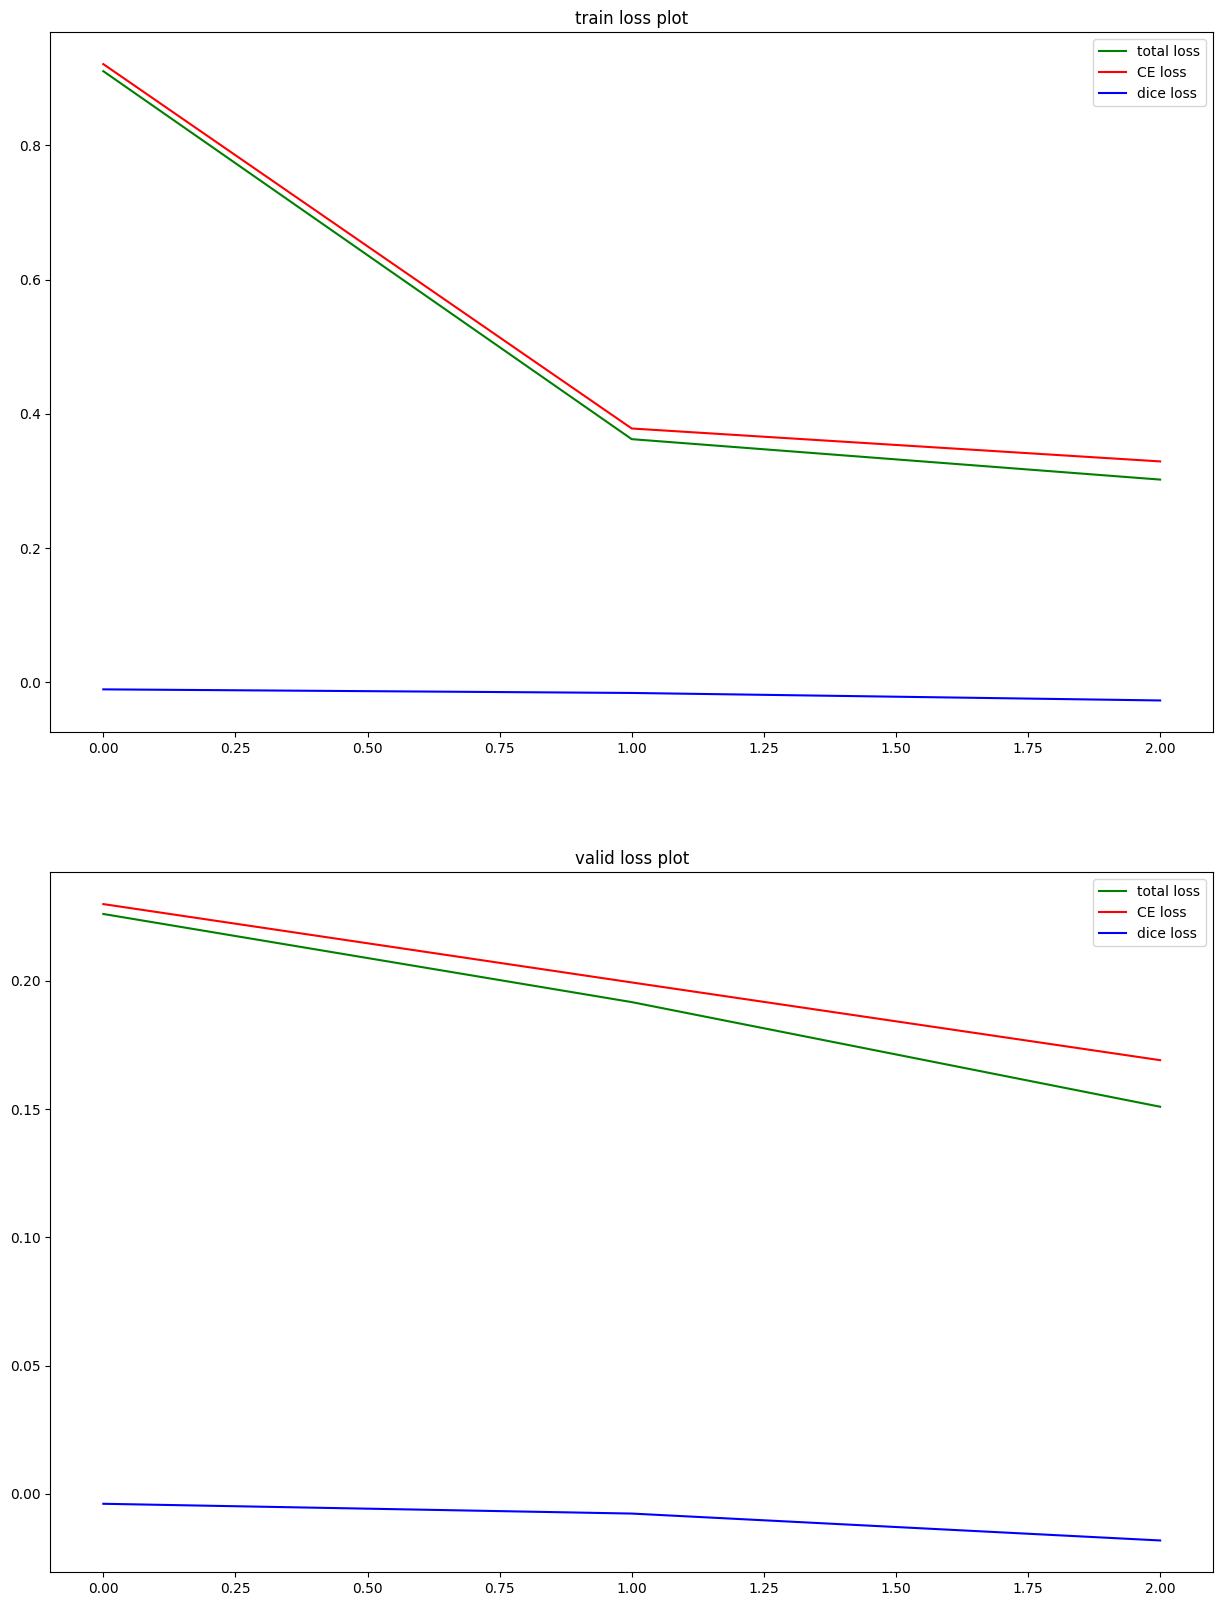

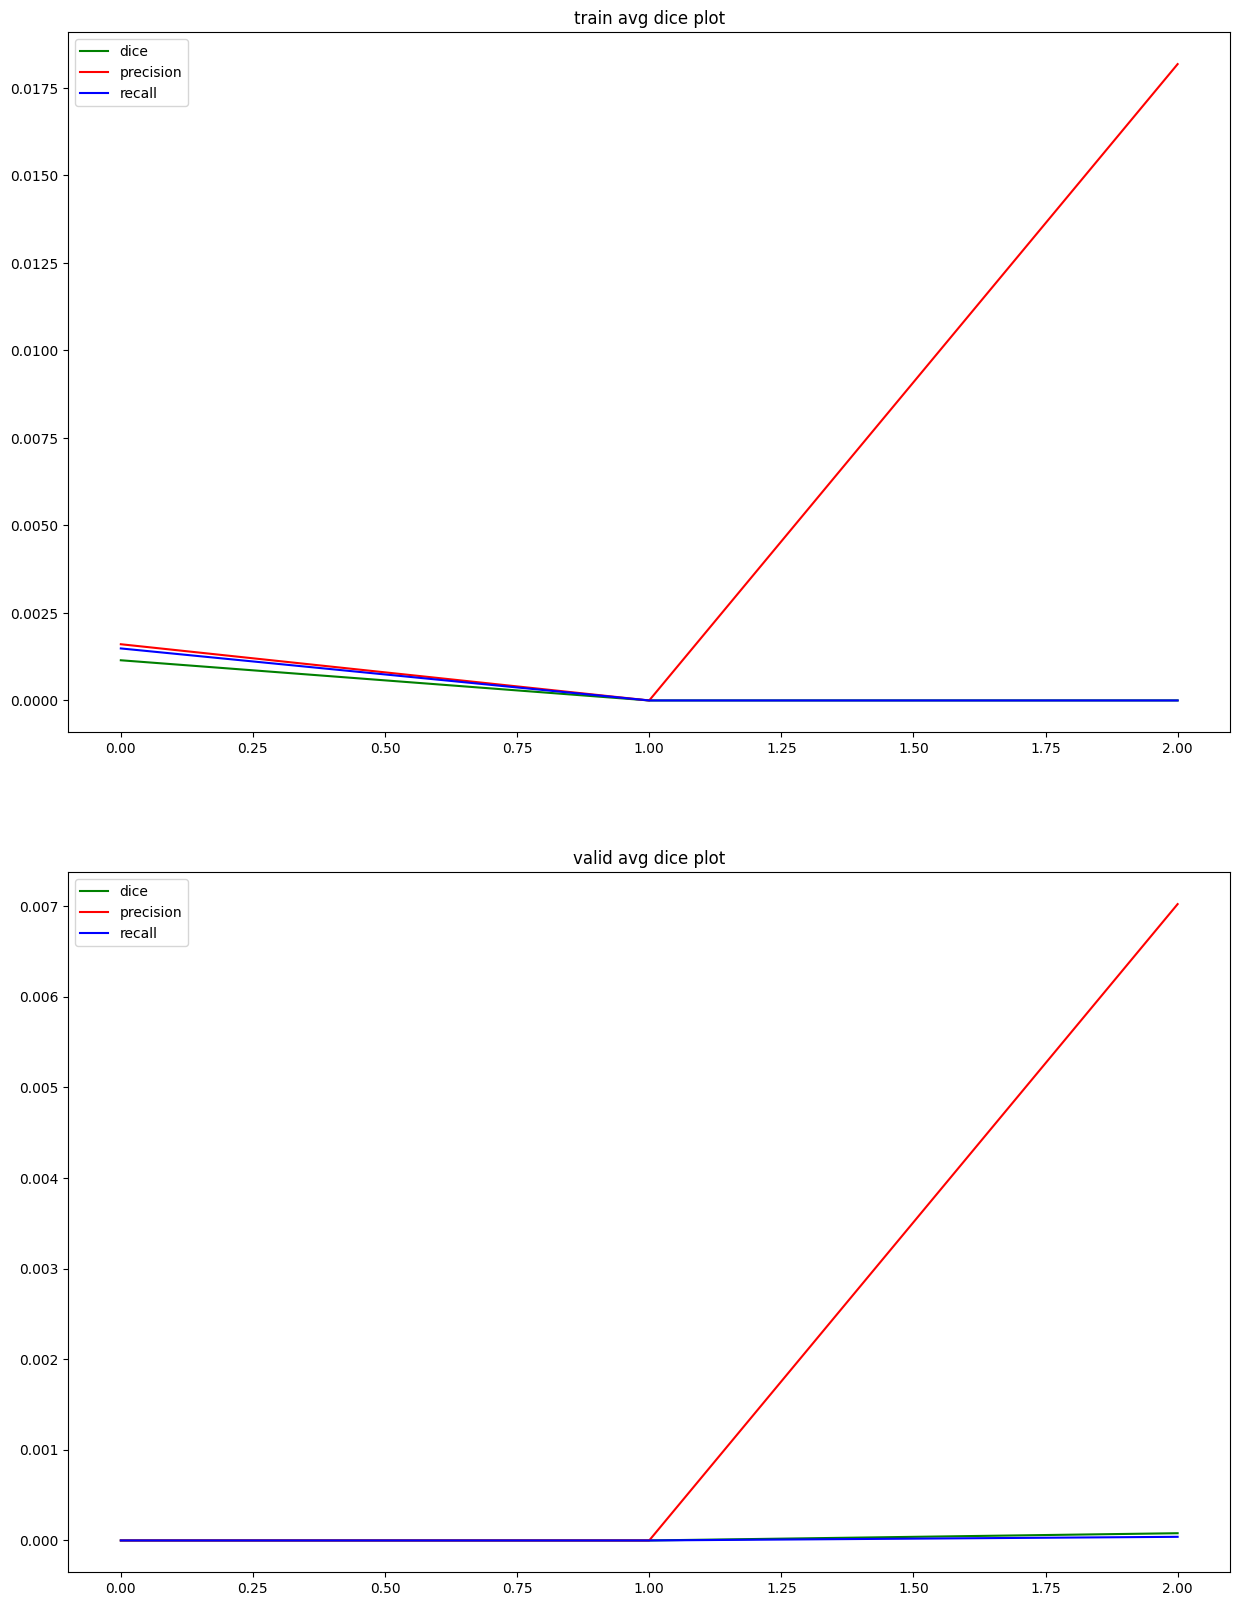

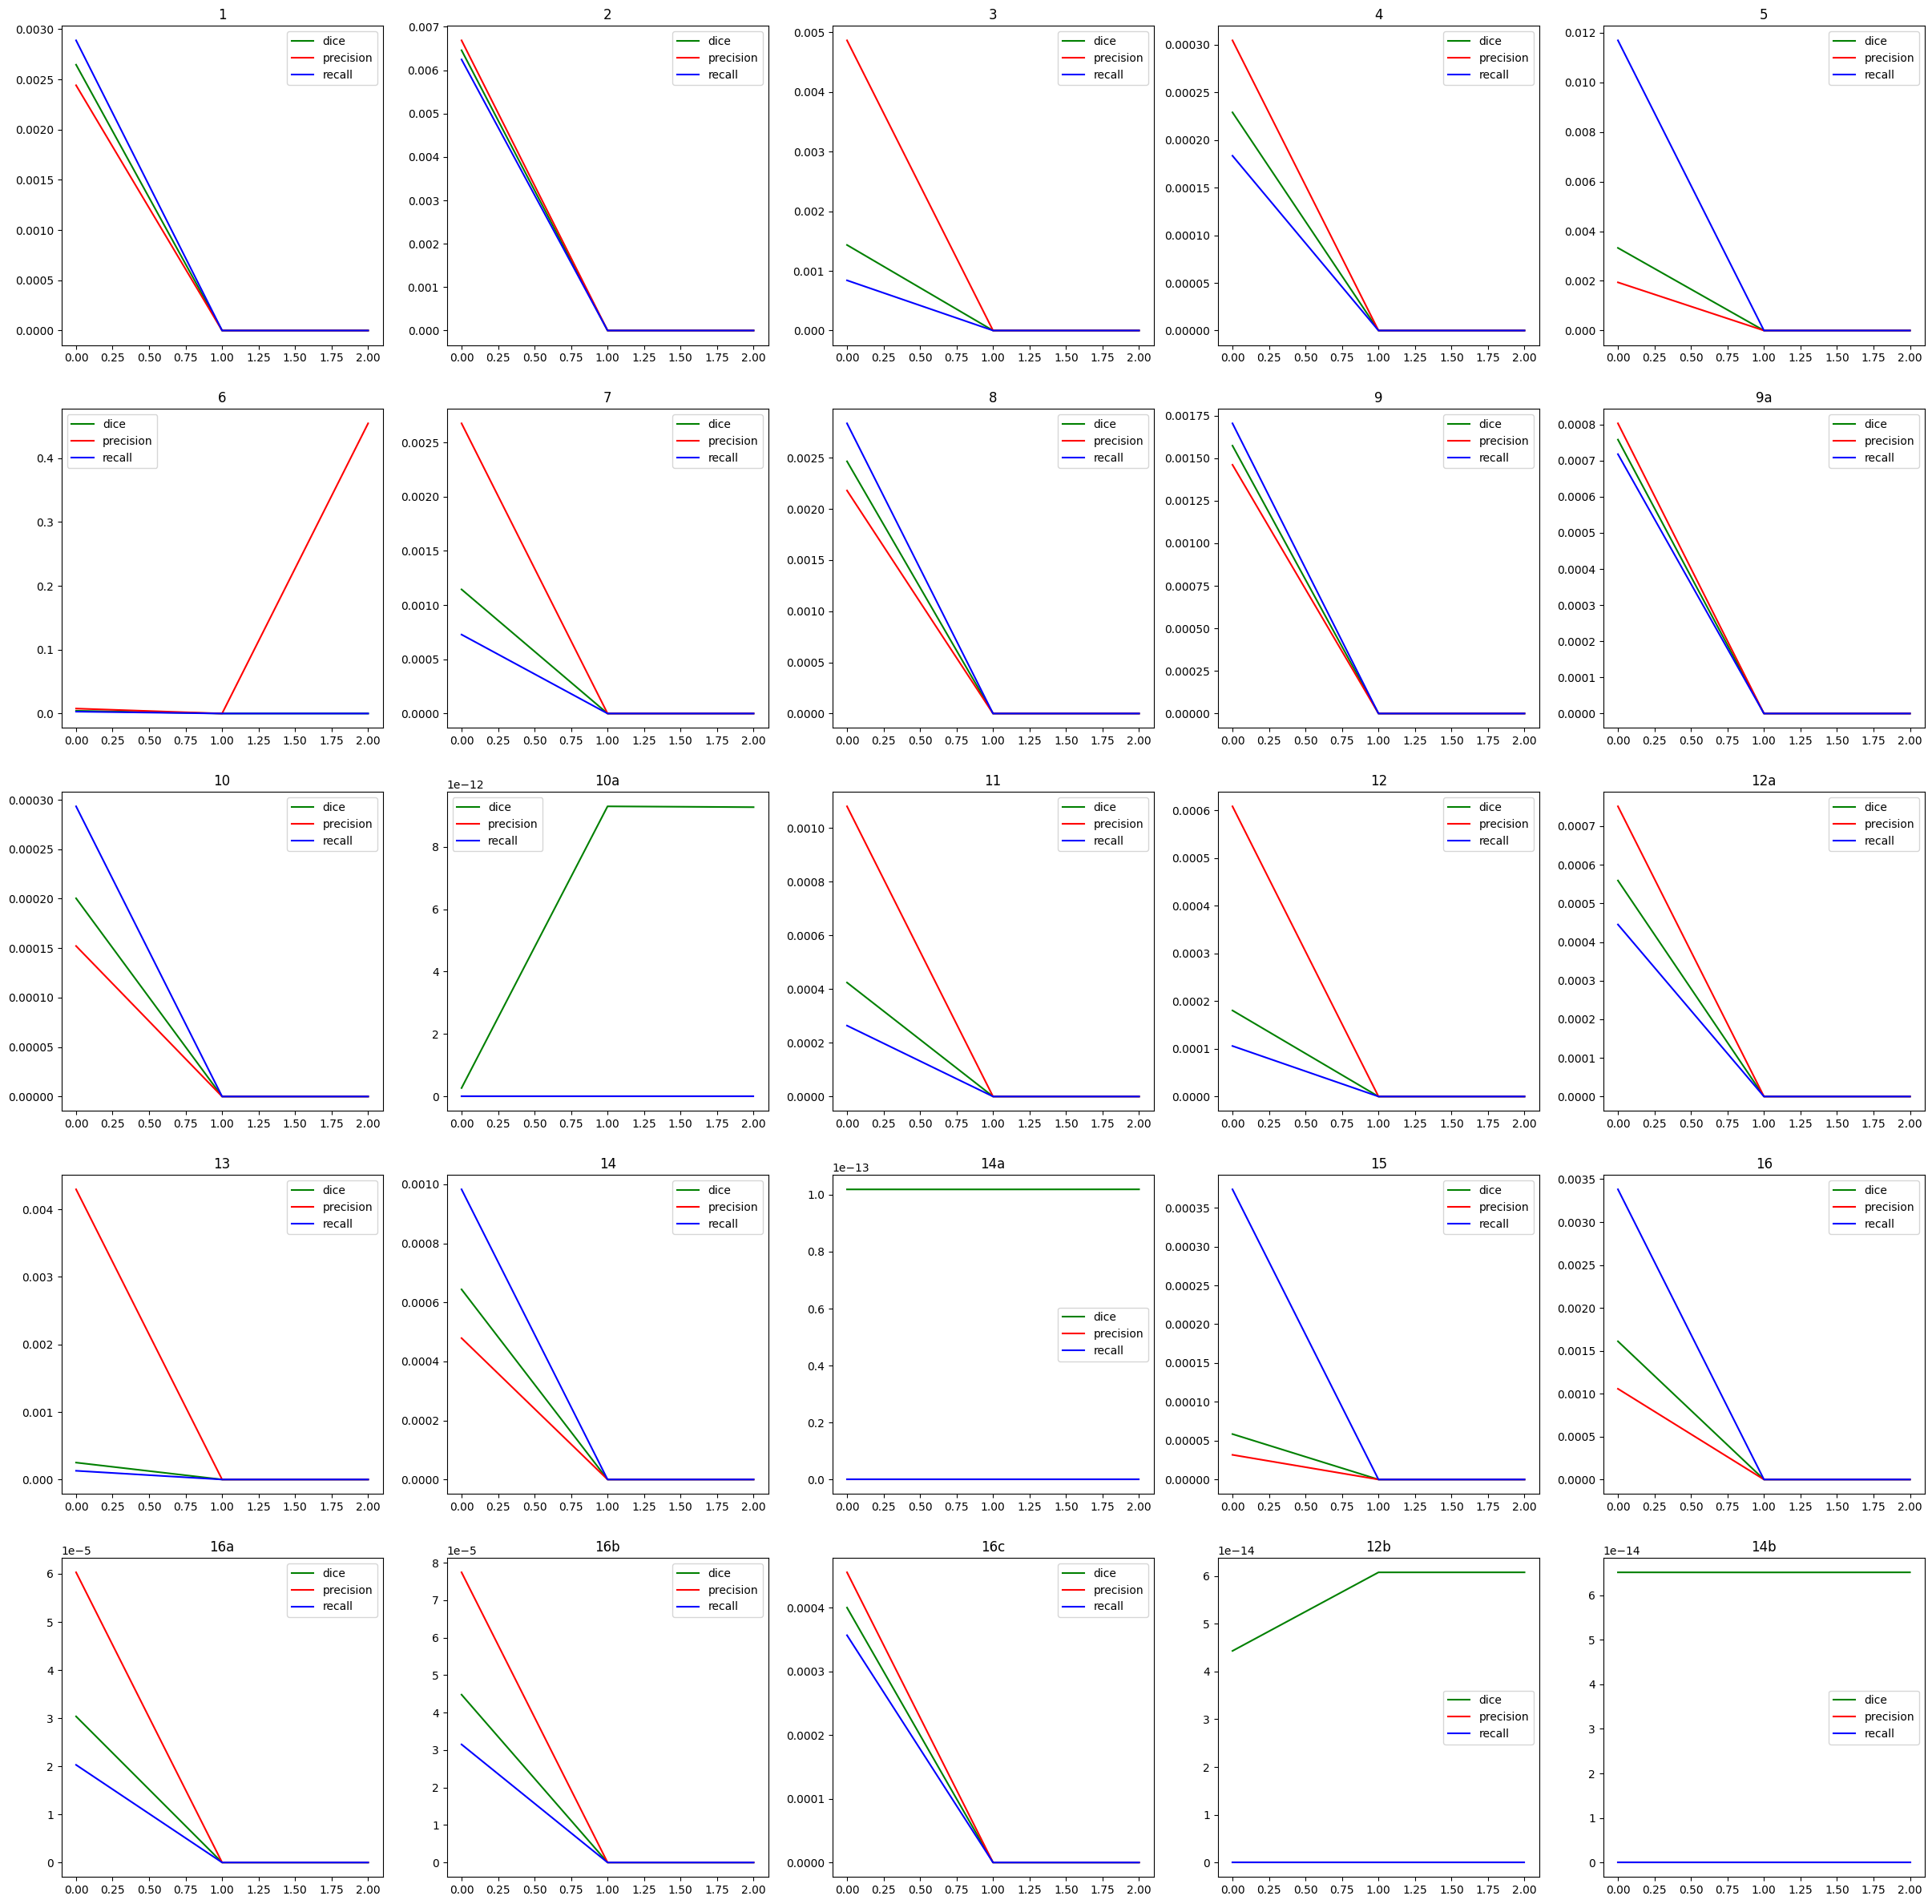

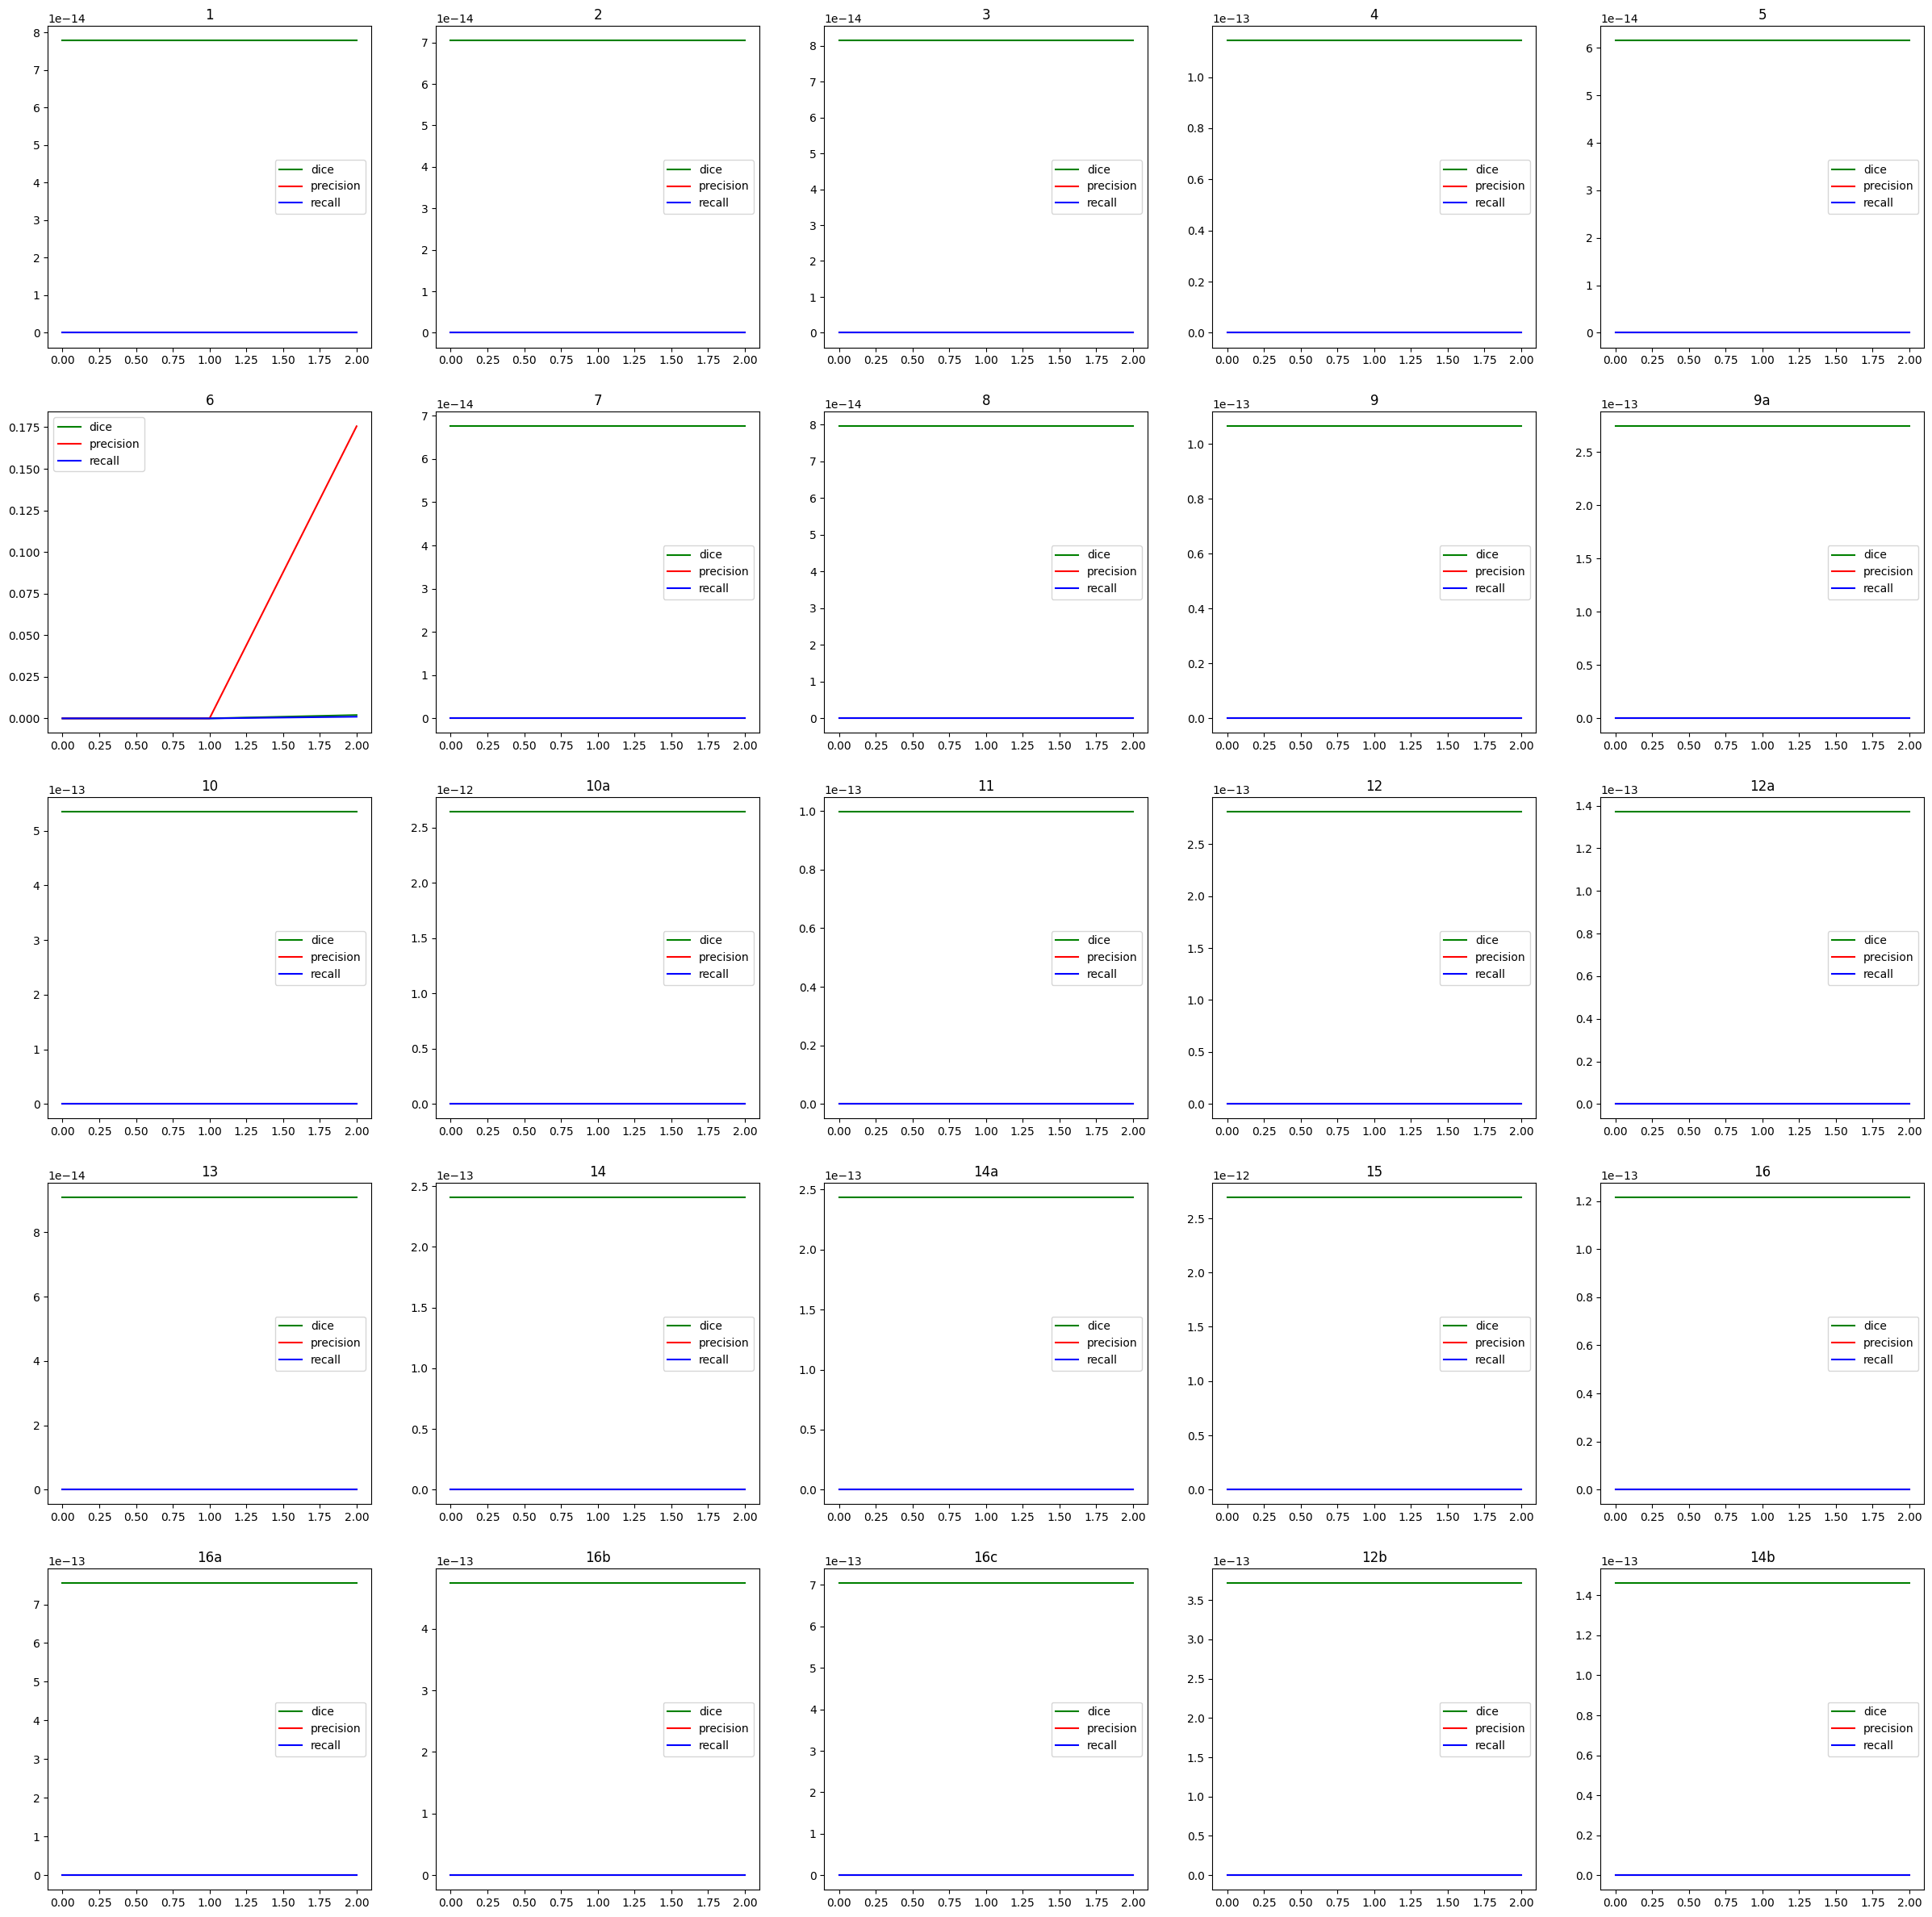

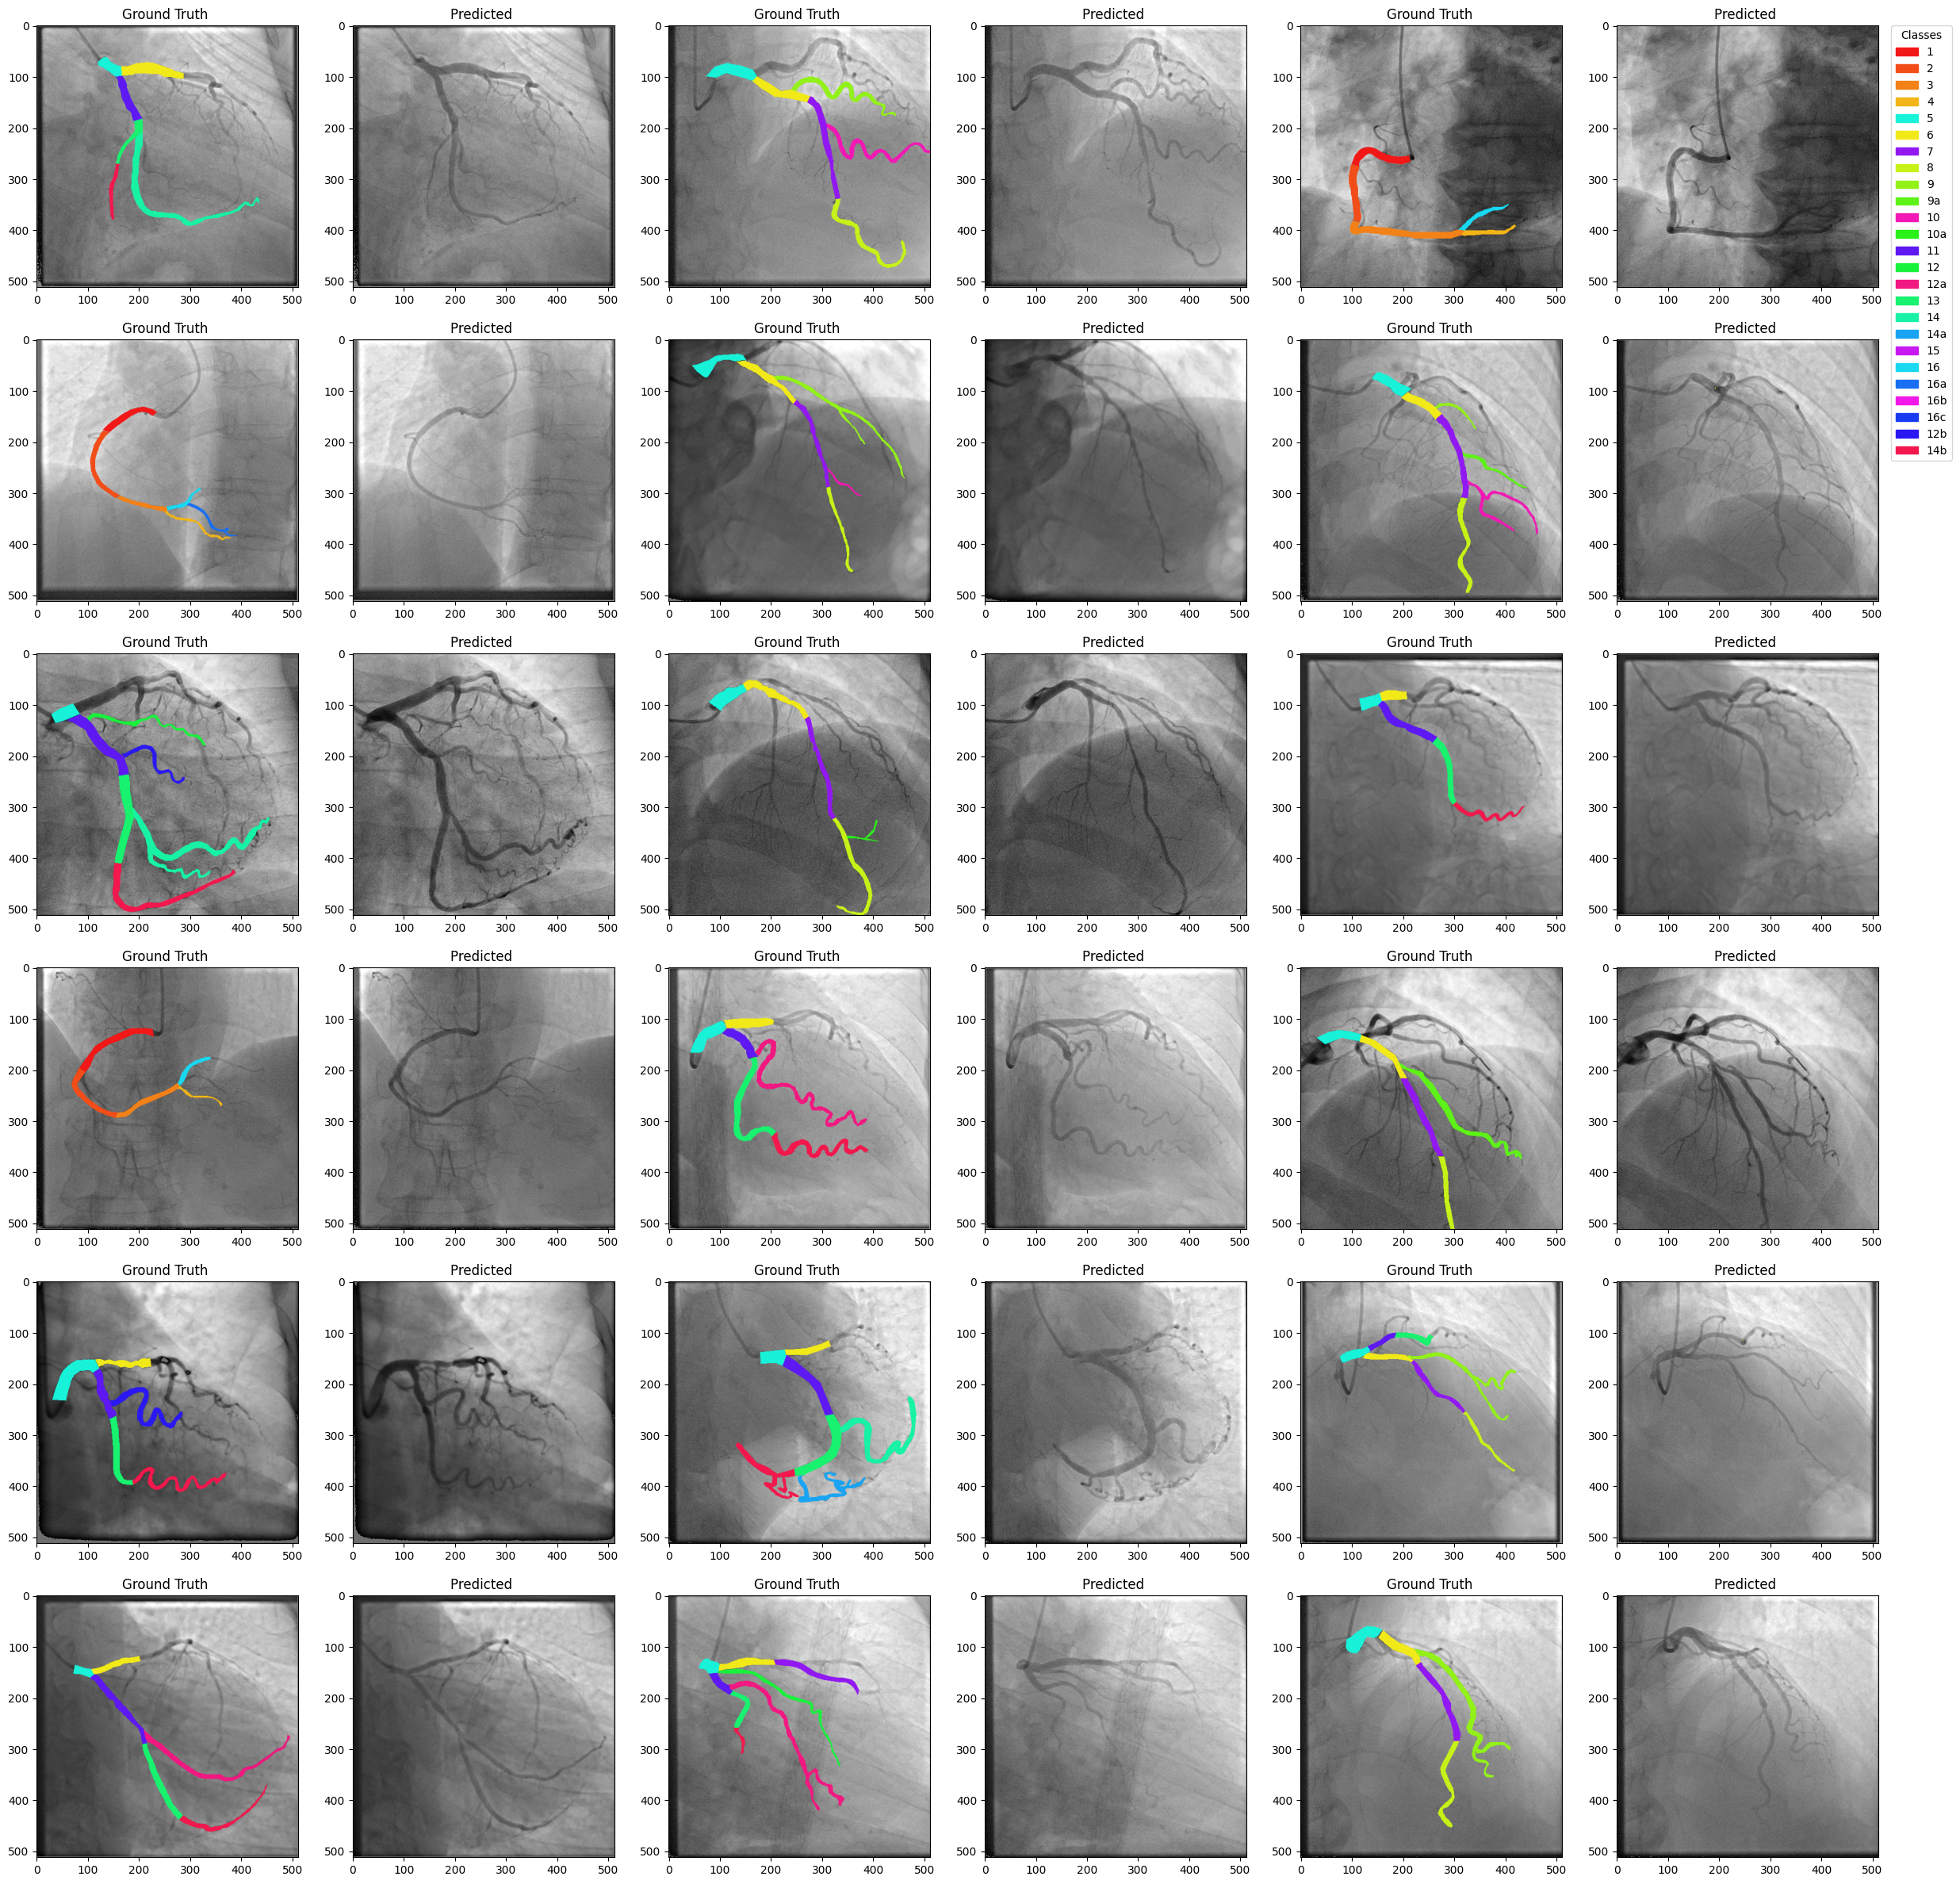

In [ ]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)